In [90]:
import pandas as pd
import datetime as dt
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt 
import functools
from tqdm import tqdm
import seaborn as sns
import quandl
import math
import statsmodels.regression.linear_model as linreg
import requests
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.regression.linear_model as linreg
import os
import plotnine as p9
from plotnine import ggplot, aes, geom_histogram, labs, facet_wrap, theme, element_text, geom_line, geom_vline


In [4]:
KEY = 'xpFGWP_Rsch8wawp_DLL'
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 

In [5]:
@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [6]:
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

In [7]:
START_DATE = '2014-01-01'
END_DATE = '2022-12-23'

In [8]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

In [9]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

In [10]:
idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

In [11]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['SPY', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

In [12]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

In [13]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022',
         'H2023']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = START_DATE
trim_end = END_DATE
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  # data = clean_quandl_columns(data)
  # data = data[data['DtT'] > 30]
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = pd.concat([finalized_data, data])
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

cl_data = finalized_data.copy()[['Future']].rename(columns={'Future':'CL'})

100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


In [14]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)

all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['SPY'].pct_change()
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

In [15]:
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])

predictors = predictors.dropna()

In [93]:
return_data = all_data[['VIX Returns', 'SPY Returns', 'SSEC Returns', 'CL Returns']]
return_data = return_data.dropna()
all_data.describe()

,VIX,Days until Event,SPY,SPY Volume,SSEC,CL,VIX Returns,SPY Returns,SSEC Returns,CL Returns
count,2262.000000,2262.000000,2262.000000,2.262000e+03,2117.000000,2331.000000,2330.000000,2330.000000,2330.000000,2330.000000
mean,18.257657,1.662688,267.562872,9.378756e+07,3107.531370,62.212214,0.003514,0.000451,0.000243,0.000381
std,7.633197,1.980849,90.114860,4.796567e+07,475.071469,19.947395,0.085996,0.011138,0.013019,0.029793
min,9.140000,0.000000,147.460782,2.027001e+07,1993.480000,11.570000,-0.259057,-0.109424,-0.084907,-0.433676
25%,13.020000,0.000000,183.667287,6.204491e+07,2898.580000,48.400000,-0.043798,-0.003518,-0.004626,-0.011768
50%,16.045000,1.000000,250.552287,8.112095e+07,3136.640000,57.350000,-0.005686,0.000441,0.000000,0.000526
75%,21.647500,3.000000,327.134030,1.107027e+08,3373.280000,71.865000,0.035993,0.005394,0.005608,0.012453
max,82.690000,12.000000,470.063508,5.072443e+08,5166.350000,117.150000,1.155979,0.090603,0.078403,0.250996


/Applications/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 69 rows containing non-finite values.


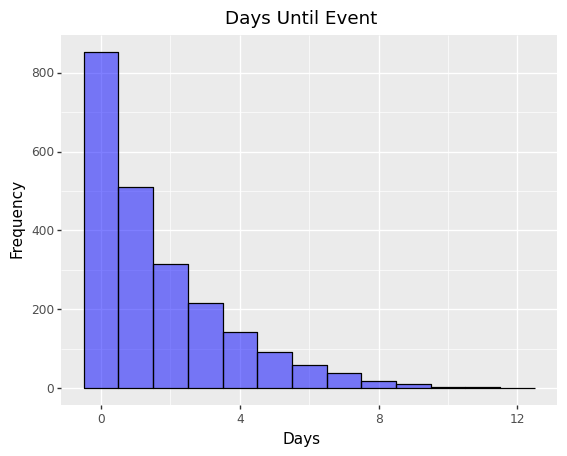

<ggplot: (8762221703623)>

In [39]:
(ggplot() 
 + aes(x=all_data[['Days until Event']])
 + geom_histogram(binwidth=1, color='black', fill='blue', alpha=0.5) 
 + labs(x='Days', y='Frequency', title='Days Until Event')
)

/Applications/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.


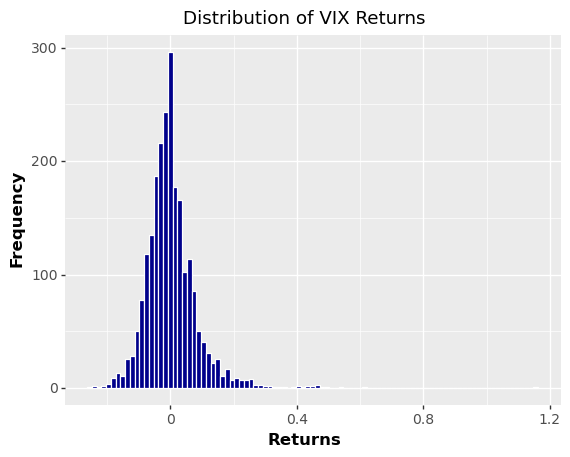

/Applications/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.


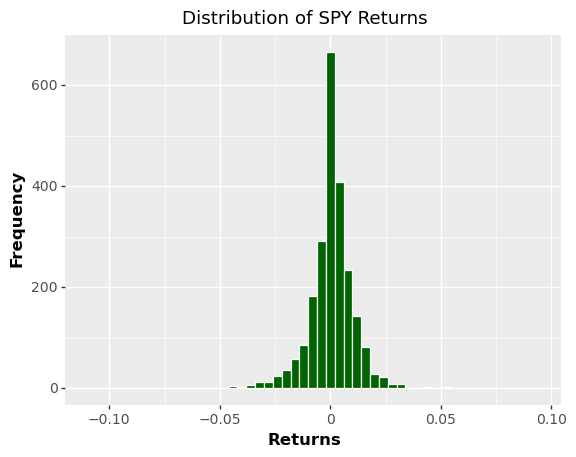

/Applications/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.


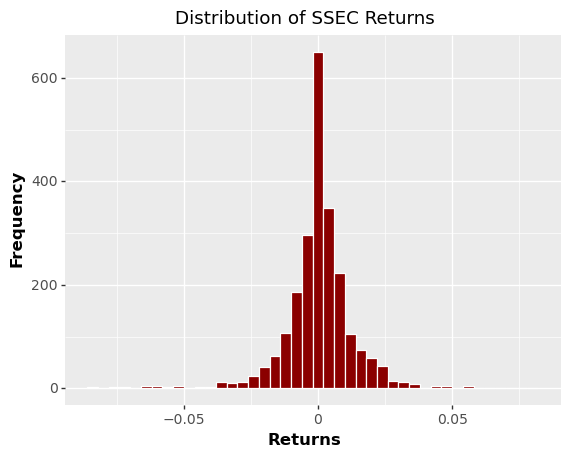

/Applications/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.


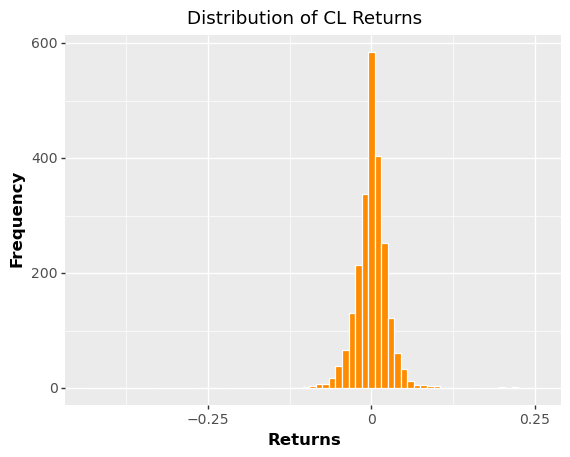

(<ggplot: (8762186429157)>,
 <ggplot: (8762186508463)>,
 <ggplot: (8762223047060)>,
 <ggplot: (8762174122472)>)

In [78]:
hist1 = (ggplot(all_data, aes(x='VIX Returns'))
         + geom_histogram(binwidth=.015, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of VIX Returns')
        )
hist2 = (ggplot(all_data, aes(x='SPY Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkgreen')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SPY Returns')
        )
hist3 = (ggplot(all_data, aes(x='SSEC Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkred')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SSEC Returns')
        )
hist4 = (ggplot(all_data, aes(x='CL Returns'))
                + geom_histogram(binwidth=.01, color='white', fill='darkorange')
                + theme(axis_text=element_text(size=10),
                        axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of CL Returns')
        )
hist1,hist2,hist3,hist4


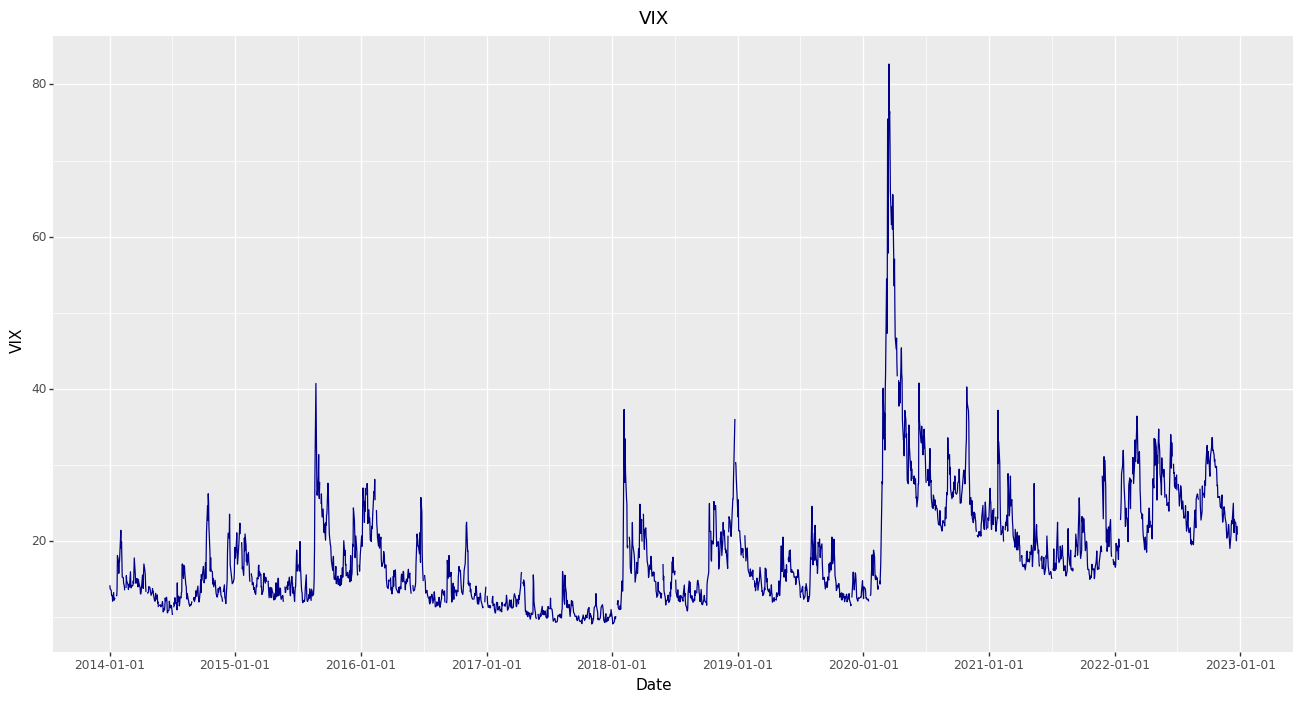

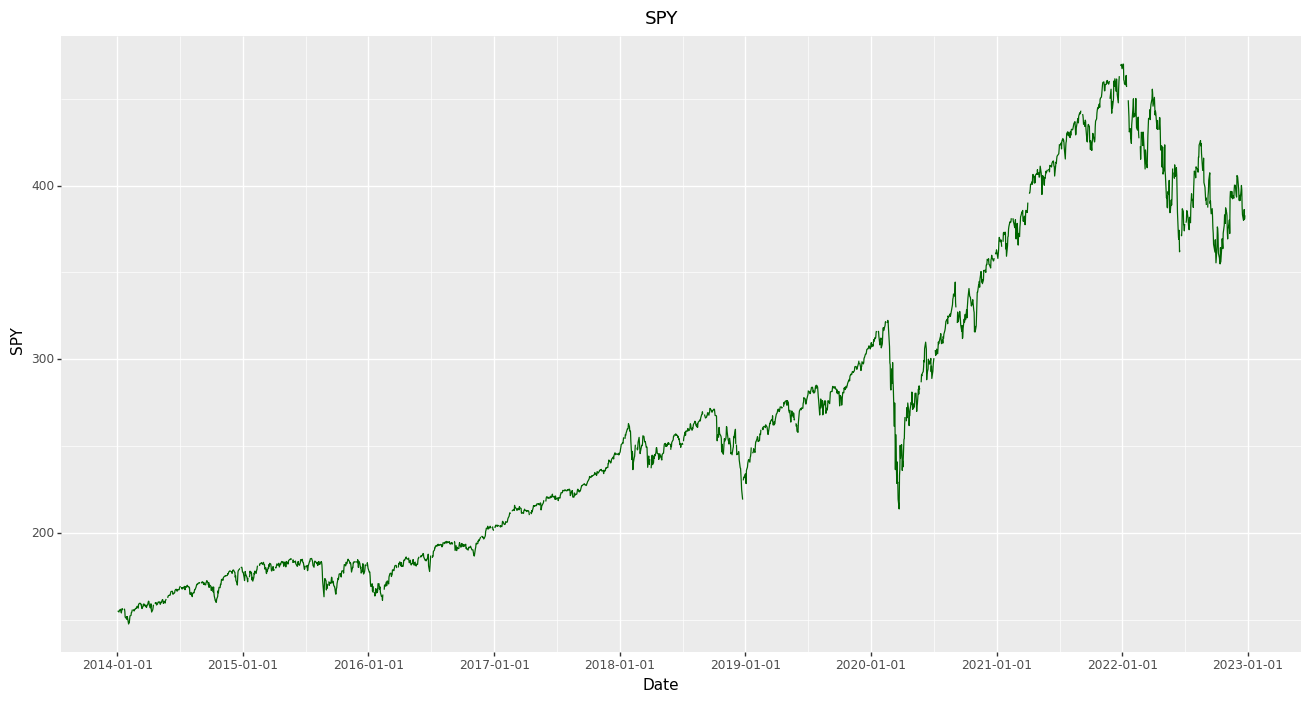

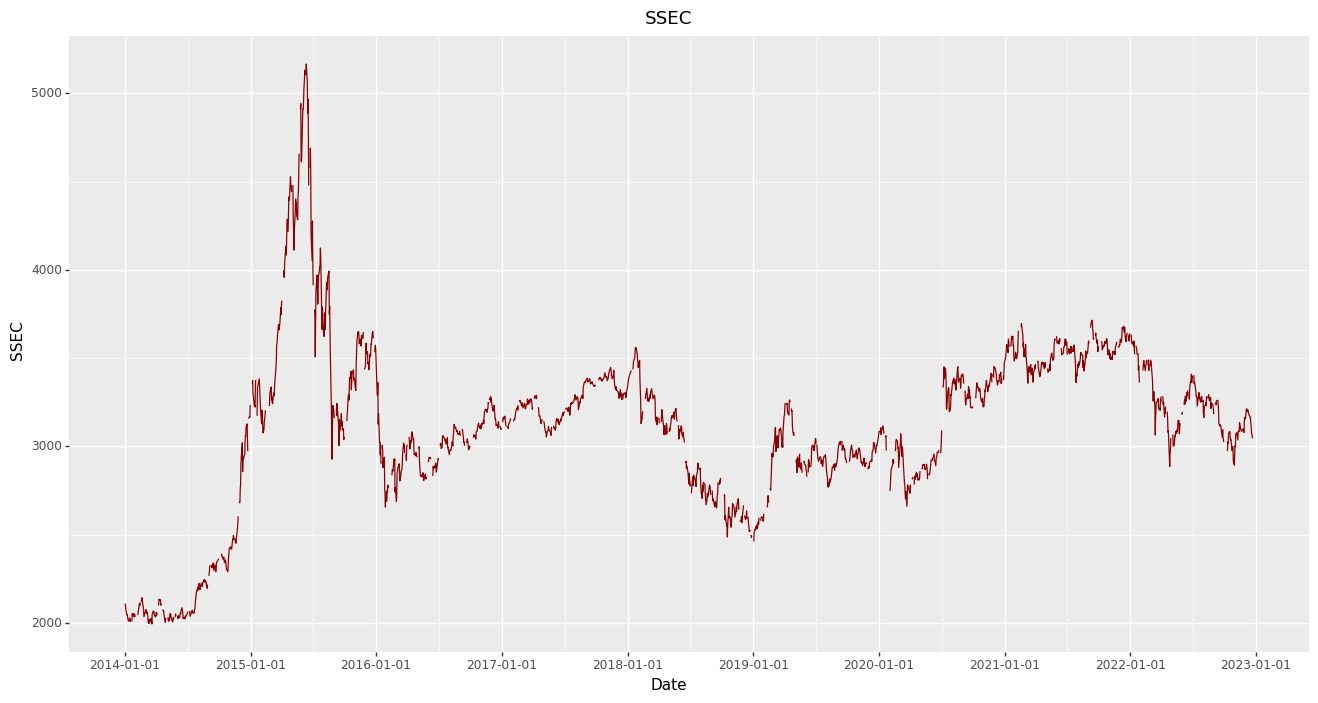

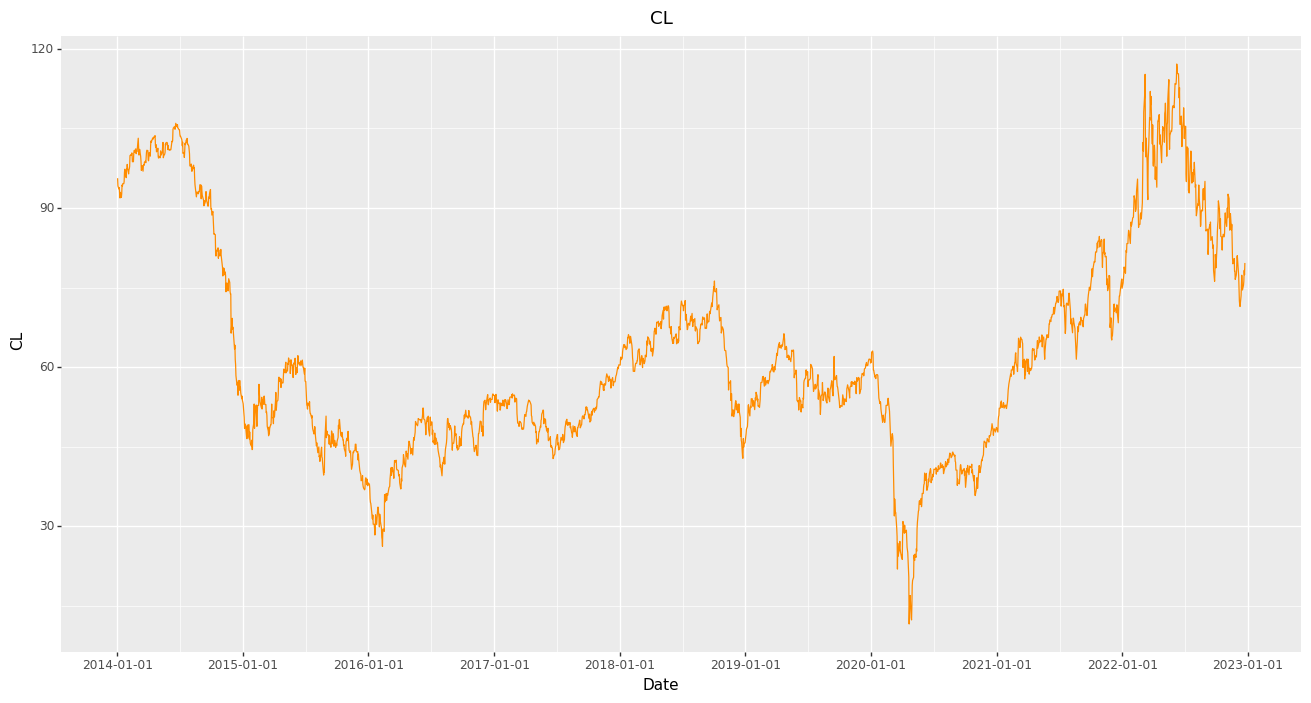

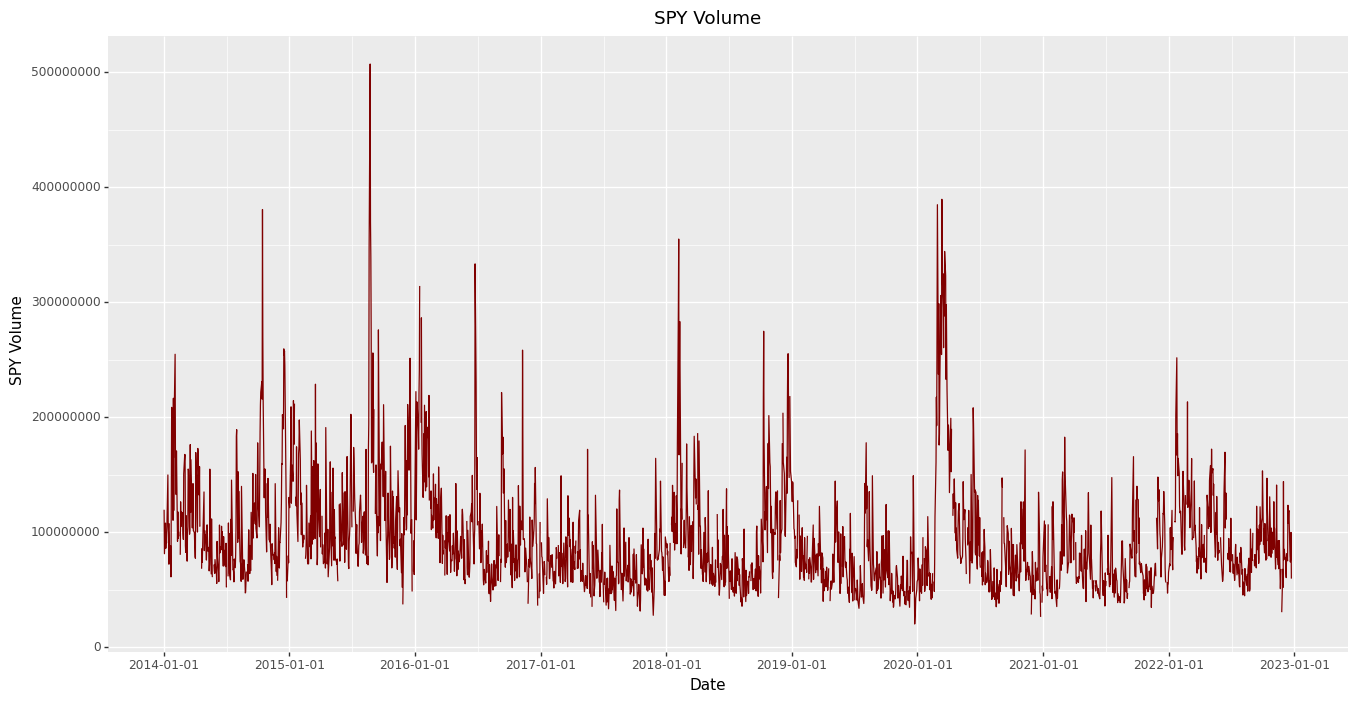

(<ggplot: (8762137054970)>,
 <ggplot: (8762137054742)>,
 <ggplot: (8762137059633)>,
 <ggplot: (8762137060154)>,
 <ggplot: (8762137052359)>)

In [92]:
vix = (ggplot(all_data[['VIX']], aes(x=all_data.index, y='VIX'))
        + geom_line(color='darkblue')
        + theme(figure_size=(16, 8))
        + labs(x='Date', y='VIX', title='VIX')
       )
spy = (ggplot(all_data[['SPY']], aes(x=all_data.index, y='SPY'))
        + geom_line(color='darkgreen')
        + theme(figure_size=(16, 8))
        + labs(x='Date', y='SPY', title='SPY')
        )
ssec = (ggplot(all_data[['SSEC']], aes(x=all_data.index, y='SSEC'))
        + geom_line(color='darkred')
        + theme(figure_size=(16, 8))
        + labs(x='Date', y='SSEC', title='SSEC')
        )
cl = (ggplot(all_data[['CL']], aes(x=all_data.index, y='CL'))
        + geom_line(color='darkorange')
        + theme(figure_size=(16, 8))
        + labs(x='Date', y='CL', title='CL')
        )
spy_volume = (ggplot(all_data[['SPY Volume']], aes(x=all_data.index, y='SPY Volume'))
        + geom_line(color='maroon')
        + theme(figure_size=(16, 8))
        + labs(x='Date', y='SPY Volume', title='SPY Volume')
        )
vix,spy,ssec,cl,spy_volume